# Análise de Dados de Transporte Público
Este notebook realiza a análise exploratória de dados relacionados ao transporte público, com foco em paradas, linhas, horários e posições de veículos.

In [3]:

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import box
from scipy.stats import gaussian_kde

# Caminhos para os arquivos
frota_path = 'data/frota_por_operadora.geojson'
horarios_path = 'data/horarios_linhas.geojson'
linhas_path = 'data/linhas_onibus.geojson'
paradas_path = 'data/paradas_onibus.geojson'
ultima_posicao_path = 'data/ultima_posicao.geojson'

# Carregando os arquivos GeoJSON
frota_gdf = gpd.read_file(frota_path)
horarios_gdf = gpd.read_file(horarios_path)
linhas_gdf = gpd.read_file(linhas_path)
paradas_gdf = gpd.read_file(paradas_path)
ultima_posicao_gdf = gpd.read_file(ultima_posicao_path)


In [4]:

# Resumo dos dados carregados
frota_gdf.info()
horarios_gdf.info()
linhas_gdf.info()
paradas_gdf.info()
ultima_posicao_gdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3035 entries, 0 to 3034
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               3035 non-null   object        
 1   id_frota                         3035 non-null   int32         
 2   data_referencia                  3035 non-null   datetime64[ms]
 3   servico                          3035 non-null   object        
 4   operadora                        3035 non-null   object        
 5   placa_veiculo                    3035 non-null   object        
 6   numero_veiculo                   3035 non-null   object        
 7   tipo_onibus                      3035 non-null   object        
 8   quantidade_passageiros_sentados  3035 non-null   int32         
 9   area_util                        3035 non-null   float64       
 10  ano_fabrica                      3035 non-null   int

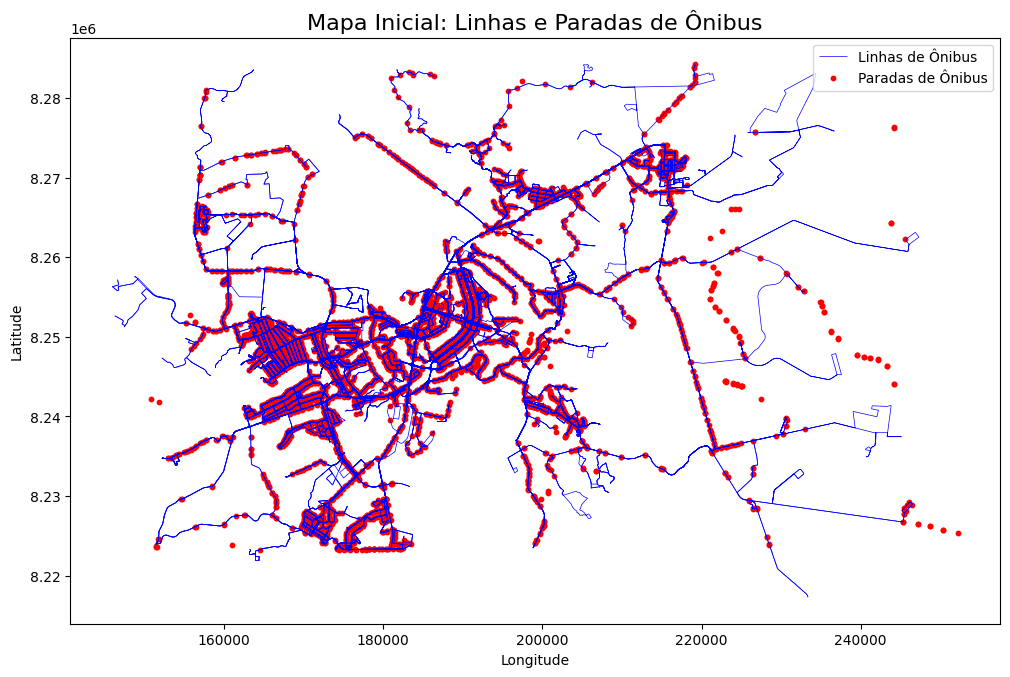

In [5]:

# Mapa Inicial: Linhas e Paradas de Ônibus
fig, ax = plt.subplots(figsize=(12, 8))
linhas_gdf.plot(ax=ax, color='blue', linewidth=0.5, label='Linhas de Ônibus')
paradas_gdf.plot(ax=ax, color='red', markersize=10, label='Paradas de Ônibus')
ax.set_title("Mapa Inicial: Linhas e Paradas de Ônibus", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


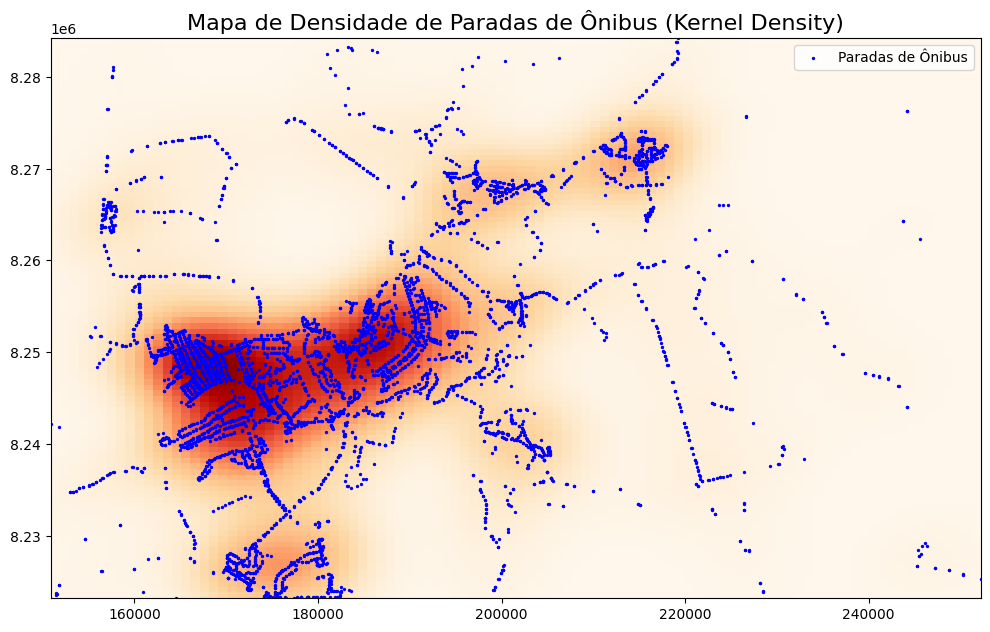

In [6]:

# Densidade de Paradas com Kernel Density Estimation (KDE)
# Extraindo coordenadas das paradas
paradas_coords = np.array([(geom.x, geom.y) for geom in paradas_gdf.geometry])

# Calculando densidade de kernel
kde = gaussian_kde(paradas_coords.T)
x_min, y_min, x_max, y_max = paradas_gdf.total_bounds
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
positions = np.vstack([x.ravel(), y.ravel()])
density = kde(positions).reshape(x.shape)

# Plotando o mapa de densidade
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(np.rot90(density), cmap='OrRd', extent=[x_min, x_max, y_min, y_max])
paradas_gdf.plot(ax=ax, color='blue', markersize=2, label='Paradas de Ônibus')
ax.set_title("Mapa de Densidade de Paradas de Ônibus (Kernel Density)", fontsize=16)
ax.legend()
plt.show()


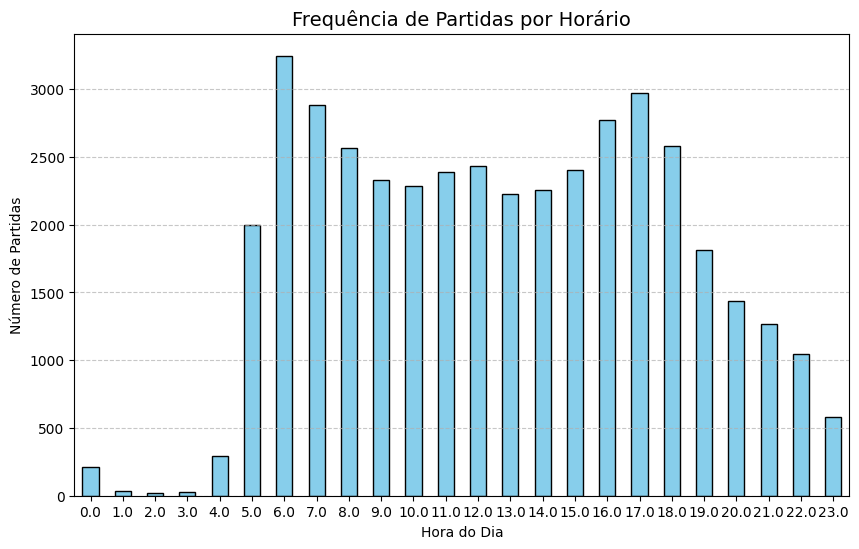

In [7]:

# Frequência de Partidas por Horário
horarios_gdf['hr_prevista'] = pd.to_datetime(horarios_gdf['hr_prevista'], format='%H:%M', errors='coerce')
horarios_gdf['hora'] = horarios_gdf['hr_prevista'].dt.hour
frequencia_por_hora = horarios_gdf.groupby('hora').size()

# Plotando a frequência por horário
fig, ax = plt.subplots(figsize=(10, 6))
frequencia_por_hora.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')
ax.set_title('Frequência de Partidas por Horário', fontsize=14)
ax.set_xlabel('Hora do Dia')
ax.set_ylabel('Número de Partidas')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.show()


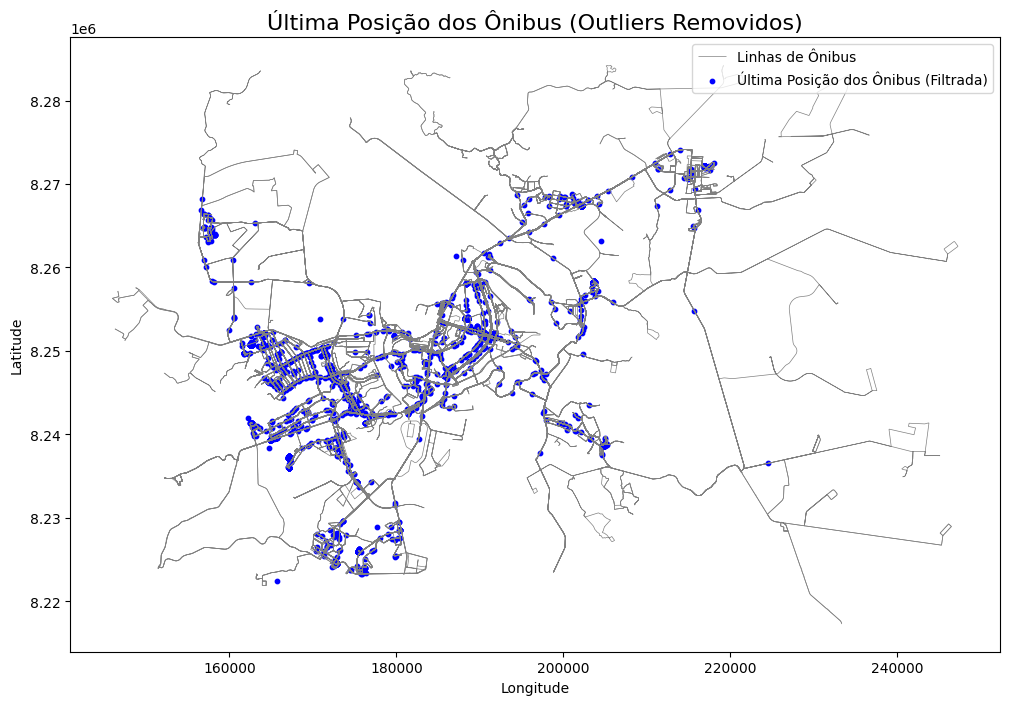

In [16]:
# Verificar se os CRS são consistentes
if linhas_gdf.crs != ultima_posicao_gdf.crs:
    ultima_posicao_gdf = ultima_posicao_gdf.to_crs(linhas_gdf.crs)

# Calcular a extensão geográfica das linhas e paradas
x_min, y_min, x_max, y_max = linhas_gdf.total_bounds

# Filtrar pontos dentro da extensão esperada
ultima_posicao_filtrada = ultima_posicao_gdf[
    (ultima_posicao_gdf.geometry.x >= x_min) &
    (ultima_posicao_gdf.geometry.x <= x_max) &
    (ultima_posicao_gdf.geometry.y >= y_min) &
    (ultima_posicao_gdf.geometry.y <= y_max)
]

# Plotar os dados filtrados
fig, ax = plt.subplots(figsize=(12, 8))
linhas_gdf.plot(ax=ax, color='gray', linewidth=0.5, label='Linhas de Ônibus')
ultima_posicao_filtrada.plot(ax=ax, color='blue', markersize=10, label='Última Posição dos Ônibus (Filtrada)')
ax.set_title("Última Posição dos Ônibus (Outliers Removidos)", fontsize=16)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()